# Functions

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

API_KEY = "007f8f538a464794a8f115446250803"
BASE_URL = "http://api.worldweatheronline.com/premium/v1/weather.ashx"

def get_future_data(city, date):

    history_url = f"{BASE_URL}?key={API_KEY}&q={city}&format=json&date={date}"
    history_data = []
    try:
        response = requests.get(history_url)

        if response.status_code == 200:
            data = response.json()

            if "data" in data and "weather" in data["data"]:
                for day in data["data"]["weather"]:
                  total_wind = 0
                  total_humidity = 0
                  total_precip = 0
                  count = 8

                  for i in range(count):
                      total_wind += float(day['hourly'][i]['windspeedKmph'])
                      total_humidity += float(day['hourly'][i]['humidity'])
                      total_precip += float(day['hourly'][i]['precipMM'])

                  day_data = {
                      'date': day['date'],
                      'avgtemp_c': float(day['avgtempC']),
                      'maxtemp_c': float(day['maxtempC']),
                      'mintemp_c': float(day['mintempC']),
                      'avgwind_kph': total_wind / count,
                      'avghumidity': total_humidity / count,
                      'totalprecip_mm': total_precip,
                      'sunHour': float(day['sunHour'])
                  }

                  history_data.append(day_data)

        else:
            print(f"Error fetching data for {date}: Status code {response.status_code}")

    except Exception as e:
        print(f"An error occurred: {e}")

    return history_data


In [ ]:
import requests
import math
from datetime import datetime, timedelta
import pandas as pd

def calculate_et(temp, humidity, solar_radiation, wind_speed, pressure=101.3, altitude=0):
    """
    Calculate reference evapotranspiration (ET) using the Penman-Monteith equation.

    Parameters:
    - temp (float): Air temperature in Celsius
    - humidity (float): Relative humidity in %
    - solar_radiation (float): Solar radiation in MJ/m²/day
    - wind_speed (float): Wind speed in m/s
    - pressure (float): Atmospheric pressure in kPa (default: 101.3 kPa at sea level)
    - altitude (float): Altitude above sea level in meters (affects pressure)

    Returns:
    - float: Evapotranspiration (ET) in mm/day
    """

    # Constants
    L = 2.45  # Latent heat of vaporization (MJ/kg)
    cp = 1.013 * 10 ** -3  # Specific heat of air (MJ/kg°C)
    epsilon = 0.622  # Ratio molecular weight of water vapor/dry air

    # Adjust atmospheric pressure by altitude (kPa)
    pressure = 101.3 * ((293 - 0.0065 * altitude) / 293) ** 5.26

    # Saturation vapor pressure (es) using temperature (kPa)
    es = 0.6108 * math.exp((17.27 * temp) / (temp + 237.3))

    # Actual vapor pressure (ea) using relative humidity (kPa)
    ea = es * (humidity / 100)

    # Slope of the saturation vapor pressure curve (delta, kPa/°C)
    delta = (4098 * es) / ((temp + 237.3) ** 2)

    # Psychrometric constant (gamma, kPa/°C)
    gamma = (cp * pressure) / (epsilon * L)

    # Net radiation (Rn) approximation (MJ/m²/day)
    Rn = solar_radiation * 0.77

    # Wind speed adjustment (2m reference height)
    u2 = wind_speed * (4.87 / math.log(67.8 * 2 - 5.42))

    # Penman-Monteith Equation (mm/day)
    ET = (0.408 * delta * Rn + gamma * (900 / (temp + 273)) * u2 * (es - ea)) / (delta + gamma * (1 + 0.34 * u2))

    return round(ET, 2)
def calculate_crop_et(ET0, crop_type, season):
    """
    Calculate the crop evapotranspiration (ETc).

    Parameters:
    - ET0 (float): Reference evapotranspiration in mm/day
    - crop_type (str): Type of crop (e.g., 'Rice', 'Olives', 'Date Palms', 'Oranges')
    - season (str): Season ('Initial', 'Mid-season', 'Late-season')

    Returns:
    - float: Crop evapotranspiration (ETc) in mm/day
    """
    kc_values = {
        'Rice': {'Initial': 1.05, 'Mid-season': 1.20, 'Late-season': 0.90},
        'Olive': {'Initial': 0.30, 'Mid-season': 0.60, 'Late-season': 0.55},
        'Date': {'Initial': 0.90, 'Mid-season': 0.95, 'Late-season': 0.85},
        'Orange': {'Initial': 0.65, 'Mid-season': 0.85, 'Late-season': 0.70}
    }

    kc = kc_values[crop_type][season]
    ETc = kc * ET0
    return ETc

def calculate_solar_radiation(sunHour, maxtemp, mintemp):
  tmax = maxtemp
  tmin = mintemp
  tmax_k = tmax + 273.15
  tmin_k = tmin + 273.15
  albedo = 0.23  # Albedo of grass reference crop
  altitude = 0
  ea = 2.5
  # Stefan-Boltzmann constant (MJ/K^4/m²/day)
  sigma = 4.903e-9

  # Clear sky solar radiation (Rso) approximation
  total_solar = sunHour * 0.2 * 4.92
  rso = (0.75 + 2e-5 * altitude) * total_solar

  # Longwave radiation (Rl)
  rl = (sigma * ((tmax_k**4 + tmin_k**4) / 2) * (0.34 - 0.14 * math.sqrt(ea))
      * (1.35 * (total_solar / rso) - 0.35))

  # Net radiation (Rn)
  rn = (1 - albedo) * total_solar - rl

  return rn

def calculate_rain_contribution(P, soil_type):
    """
    Calculate the rain contribution to soil moisture based on soil type.

    Parameters:
    - P (float): Precipitation (rainfall) in mm/day
    - soil_type (str): Type of soil ('Sandy', 'Loamy', 'Clay')

    Returns:
    - float: Rain contribution to soil moisture in mm/day
    """
    infiltration_efficiency = {
        'Sandy': 0.85,
        'Loamy': 0.60,
        'Clay': 0.50
    }

    if soil_type not in infiltration_efficiency:
        raise ValueError("Invalid soil type. Choose from 'Sandy', 'Loamy', or 'Clay'.")

    rain_contribution = P * infiltration_efficiency[soil_type]
    return rain_contribution


In [ ]:
def calculate_soil_moisture_delta_from_df_row(row, altitude=0):
    """
    Calculate daily soil moisture change (mm/day) from weather data.

    Parameters:
    - row (Series): Pandas row with columns:
        avgtemp_c, maxtemp_c, mintemp_c, avgwind_kph, avghumidity, totalprecip_mm, sunHour
    - altitude (float): Altitude in meters (default: 0)

    Returns:
    - float: Net change in soil moisture (mm/day)
    """
    # Extract weather inputs
    temp = row['avgtemp_c']
    tmax = row['maxtemp_c']
    tmin = row['mintemp_c']
    wind_speed_mps = row['avgwind_kph'] / 3.6  # Convert kph to m/s
    humidity = row['avghumidity']
    rain_mm = row['totalprecip_mm']
    sun_hours = row['sunHour']

    # Calculate solar radiation (MJ/m²/day)
    solar_radiation = calculate_solar_radiation(sun_hours, tmax, tmin)

    # Calculate evapotranspiration (mm/day)
    et = calculate_et(temp, humidity, solar_radiation, wind_speed_mps, altitude=altitude)

    # Net soil moisture change (mm)
    delta_soil_moisture = et

    return round(delta_soil_moisture, 2)


# Getting Data Ready

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

df = pd.read_excel('final_data.xls')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df = df.drop(df.columns[0], axis=1)
df['soil_moisture_delta'] = df.apply(calculate_soil_moisture_delta_from_df_row, axis=1)

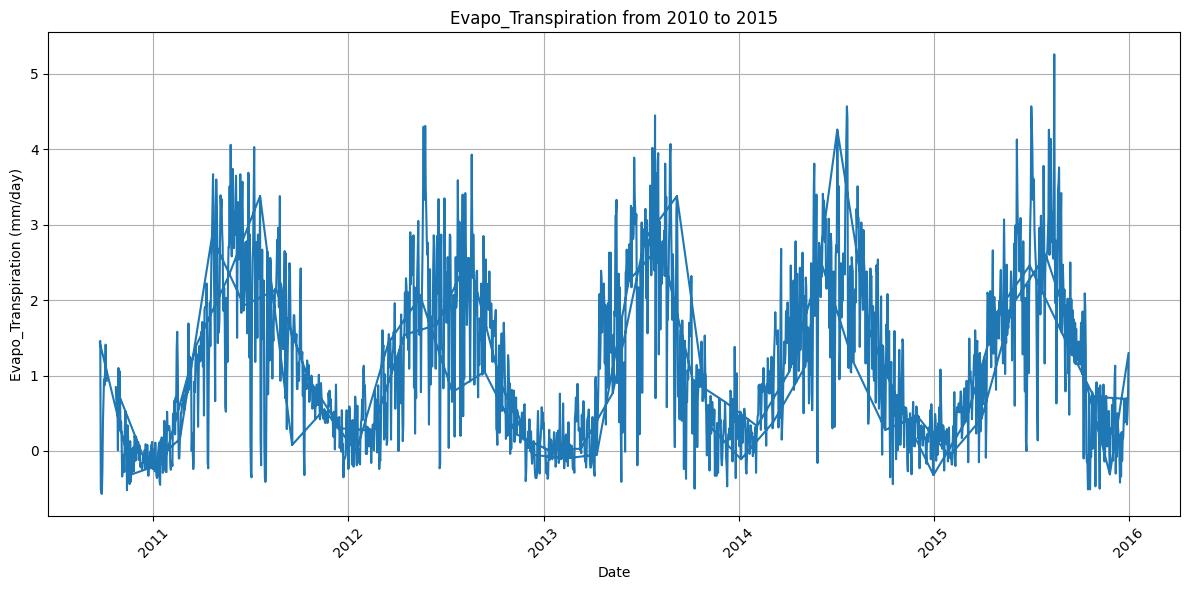

In [ ]:
# prompt: draw soil_moisture_delta from 2010-2015

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already been processed as in your provided code.
# If not, please include the code to create and prepare the 'df' DataFrame.

# Filter data for the period 2010-2015
df_2010_2015 = df[(df.index >= '2010-01-01') & (df.index <= '2015-12-31')]

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(df_2010_2015.index, df_2010_2015['soil_moisture_delta'])
plt.xlabel('Date')
plt.ylabel('Evapo_Transpiration (mm/day)')
plt.title('Evapo_Transpiration from 2010 to 2015')
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
df1 = df[['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour', 'soil_moisture_delta']]

In [ ]:
df1.to_json('weather_data.json', orient='records')

df1

,avgtemp_c,maxtemp_c,mintemp_c,avgwind_kph,avghumidity,totalprecip_mm,sunHour,soil_moisture_delta
date,,,,,,,,
2025-03-08,10,15,6,9.375,59.750,0.0,11,1.67
2025-03-09,10,15,6,8.500,58.500,0.0,11,1.63
2025-03-10,10,15,7,7.125,66.000,0.0,12,1.38
2025-03-11,9,13,5,6.250,66.875,0.0,9,0.96
2025-03-12,7,8,5,7.750,72.625,0.8,2,0.26
...,...,...,...,...,...,...,...,...
2010-10-02,9,14,5,12.875,85.875,0.0,11,0.87
2010-10-03,12,16,7,15.375,84.625,0.0,11,1.07
2010-10-04,13,17,8,17.500,80.125,0.0,11,1.41


# Training Models

## CNN Model

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314 - mae: 0.1277
Test MAE: 0.1251
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 0.1726
R² Score: 0.9777
Approximate Percentage Accuracy: 62.85%


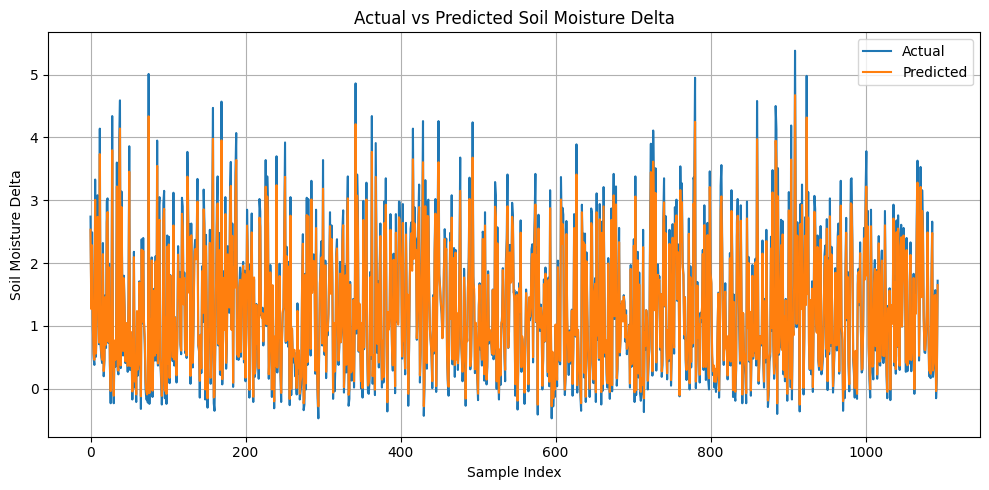

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, Dropout

# Assuming df1 is already defined with the relevant columns
features = ['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour']
target = 'soil_moisture_delta'

X = df1[features].values
y = df1[target].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for CNN input: (samples, timesteps, features) => (n, 7, 1)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build CNN model
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Approximate percentage accuracy for interpretation
mask = y_test != 0
accuracy = 100 - np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
# accuracy_percent = 100 - np.mean(np.abs((y_test - y_pred) / y_test) * 100)
print(f"Approximate Percentage Accuracy: {accuracy:.2f}%")

# Plot predicted vs actual
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Soil Moisture Delta')
plt.xlabel('Sample Index')
plt.ylabel('Soil Moisture Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## XGBOOST Model

MAE: 0.058, RMSE: 0.081, R²: 0.995, % Correct: 84.83%


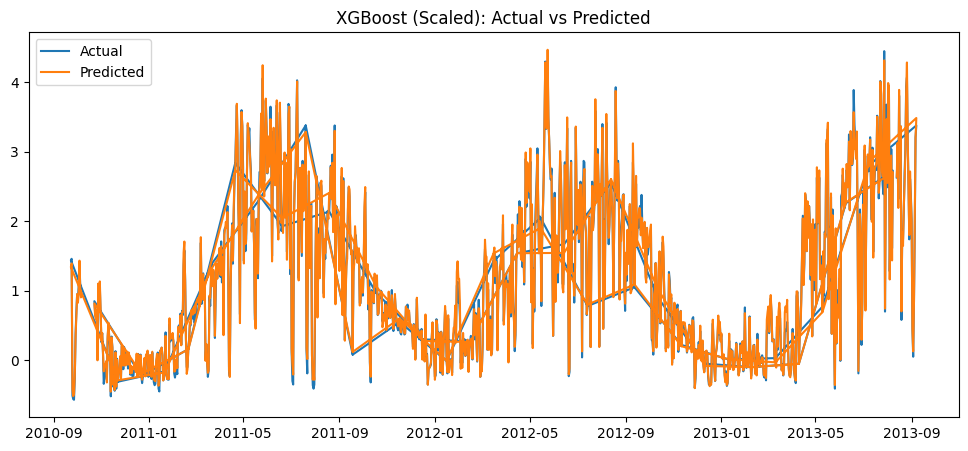

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load and preprocess data
df = pd.read_excel('final_data.xls')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df = df.drop(df.columns[0], axis=1)
df['soil_moisture_delta'] = df.apply(calculate_soil_moisture_delta_from_df_row, axis=1)

# Select features and target
df1 = df[['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour', 'soil_moisture_delta']]
X = df1.drop(columns='soil_moisture_delta')
y = df1['soil_moisture_delta']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Scale X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Optionally scale y
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Train model
model = XGBRegressor()
model.fit(X_train_scaled, y_train_scaled)
joblib.dump(model, 'xgb_model.pkl')

# Predict (scaled)
y_pred_scaled = model.predict(X_test_scaled)

# Inverse scale predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mask = y_test != 0
accuracy = 100 - np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}, % Correct: {accuracy:.2f}%")

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('XGBoost (Scaled): Actual vs Predicted')
plt.legend()
plt.show()


## PROPHET Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2c2wa2k/igtinly4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2c2wa2k/9xa00m27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45578', 'data', 'file=/tmp/tmpe2c2wa2k/igtinly4.json', 'init=/tmp/tmpe2c2wa2k/9xa00m27.json', 'output', 'file=/tmp/tmpe2c2wa2k/prophet_model3e8sb63s/prophet_model-20250501191907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.734, RMSE: 0.934, R²: 0.298, % Correct: -317.09%


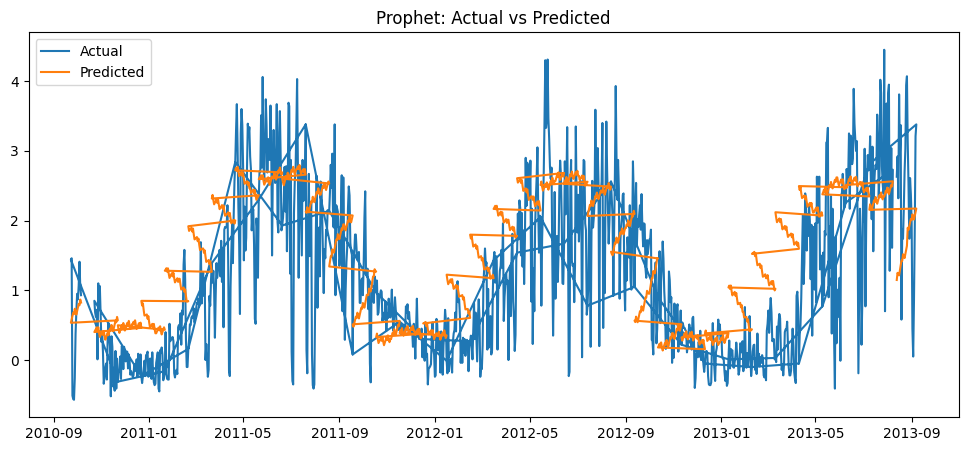

In [ ]:
from prophet import Prophet

df = pd.read_excel('final_data.xls')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df = df.drop(df.columns[0], axis=1)
df['soil_moisture_delta'] = df.apply(calculate_soil_moisture_delta_from_df_row, axis=1)

df1 = df[['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour', 'soil_moisture_delta']]

# Reformat for Prophet
prophet_df = df1[['soil_moisture_delta']].copy()
prophet_df = prophet_df.rename(columns={'soil_moisture_delta': 'y'})
prophet_df['ds'] = prophet_df.index

# Train/test
train_size = int(len(prophet_df) * 0.8)
train = prophet_df[:train_size]
test = prophet_df[train_size:]

# Train Prophet
model = Prophet()
model.fit(train)

# Forecast
future = test[['ds']]
forecast = model.predict(future)

# Evaluation
y_test = test['y'].values
y_pred = forecast['yhat'].values
max_val = max(y_pred)
min_val = min(y_pred)

y_pred = max_val + min_val - y_pred


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mask = y_test != 0
accuracy = 100 - np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}, % Correct: {accuracy:.2f}%")

# Plot
plt.figure(figsize=(12,5))
plt.plot(test['ds'], y_test, label='Actual')
plt.plot(test['ds'], y_pred, label='Predicted')
plt.title('Prophet: Actual vs Predicted')
plt.legend()
plt.show()


## SARIMA Model

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# # Load and preprocess the data
# df = pd.read_excel('final_data.xls')
# df = df.set_index('date')
# df.index = pd.to_datetime(df.index)
# df = df.drop(df.columns[0], axis=1)

# # Your custom function for calculating soil_moisture_delta
df['soil_moisture_delta'] = df.apply(calculate_soil_moisture_delta_from_df_row, axis=1)

# Select features
df1 = df[['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour', 'soil_moisture_delta']]

# Train/test split
train_size = int(len(df1) * 0.8)
X = df1.drop(columns='soil_moisture_delta')
y = df1['soil_moisture_delta']

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Fit SARIMAX model with exogenous variables
model = sm.tsa.statespace.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(2,1,2),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
joblib.dump(model, 'sarimax_model.pkl')

# Forecast
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
y_pred = forecast.predicted_mean
y_pred.index = y_test.index  # Align indices

# Evaluation
mask = y_test != 0  # Avoid division by zero in accuracy calculation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

MAE: 0.255
RMSE: 0.364
R²: 0.893
% Correct: -124.78%


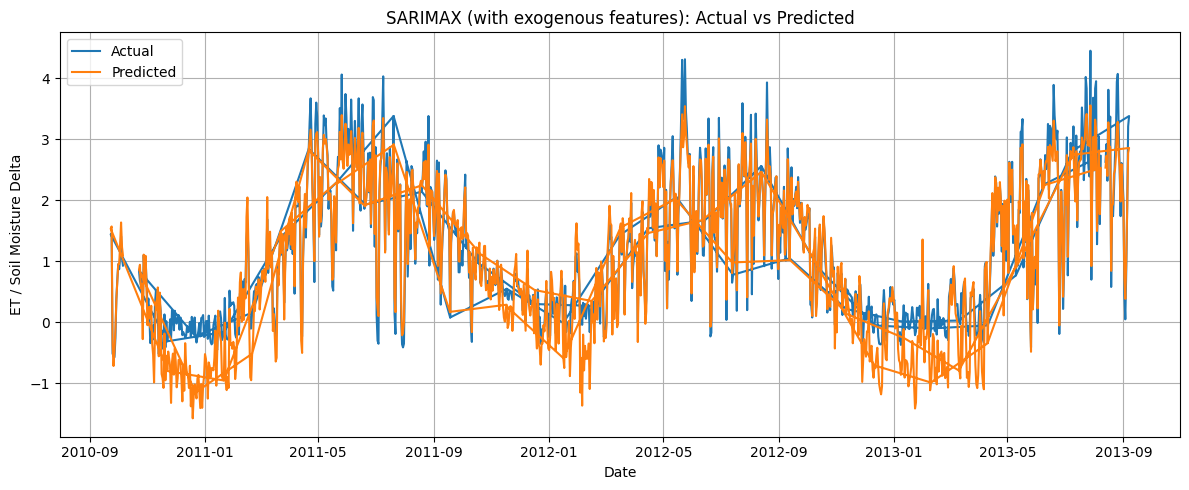

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_score = mape(y_test, y_pred)
accuracy = 100 - mape_score


print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"% Correct: {accuracy:.2f}%")

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_pred.index, y_pred, label='Predicted')
plt.title('SARIMAX (with exogenous features): Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('ET / Soil Moisture Delta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM Model

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0135
Epoch 2/3
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0081
Epoch 3/3
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0082
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.475, RMSE: 0.648, R²: 0.661, % Correct: 58.21%


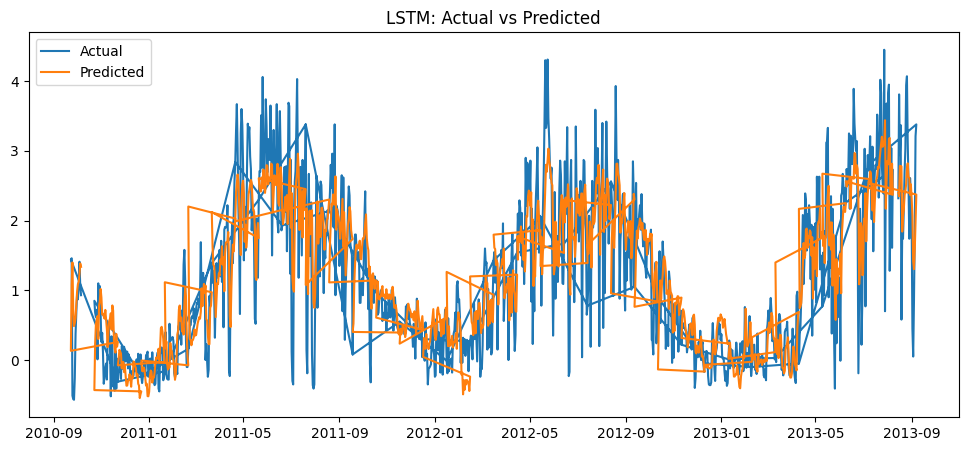

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Select features
df1 = df[['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour', 'soil_moisture_delta']]


# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df1)

# Prepare sequences
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

sequence_length = 10
X_all, y_all = create_sequences(scaled, sequence_length)

split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

# LSTM Model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(loss='mse', optimizer=Adam(0.001))
model.fit(X_train, y_train, epochs=3, batch_size=16, verbose=1)

# Predict
y_pred = model.predict(X_test).flatten()

# Rescale back to original
y_test_rescaled = scaler.inverse_transform(
    np.concatenate((X_test[:, -1], y_test.reshape(-1, 1)), axis=1))[:, -1]

y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((X_test[:, -1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

# Evaluation
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mask = y_test != 0
accuracy = 100 - np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100


print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}, % Correct: {accuracy:.2f}%")




# Plot
plt.figure(figsize=(12,5))
plt.plot(df1.index[-len(y_test_rescaled):], y_test_rescaled, label='Actual')
plt.plot(df1.index[-len(y_test_rescaled):], y_pred_rescaled, label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.legend()
plt.show()


## Random Forest Model

Random Forest
RMSE: 0.1113
R² Score: 0.9907
Approximate Percentage Accuracy: 88.19%


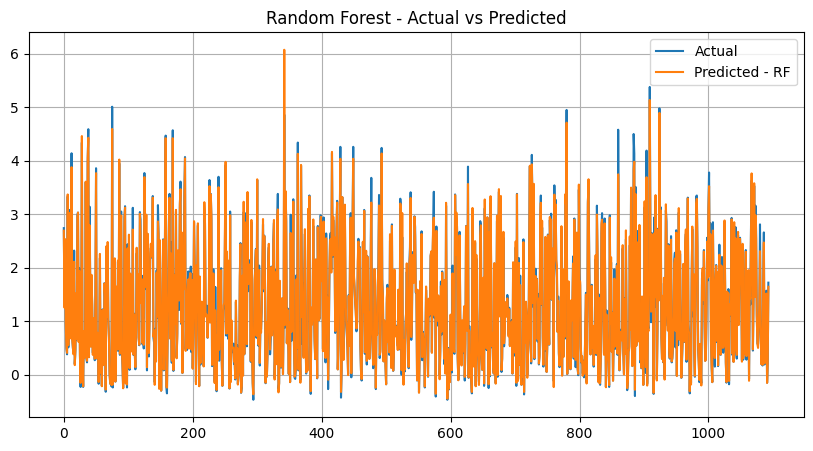

In [ ]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming df1 is already defined
features = ['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour']
target = 'soil_moisture_delta'

X = df1[features].values
y = df1[target].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === 1. Random Forest ===
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'rf_model.pkl')
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mask = y_test != 0
accuracy_rf = 100 - np.mean(np.abs((y_test[mask] - y_pred_rf[mask]) / y_test[mask])) * 100
print("Random Forest")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")
print(f"Approximate Percentage Accuracy: {accuracy_rf:.2f}%")

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_rf, label='Predicted - RF')
plt.title('Random Forest - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## Decision Tree Model

Decision Tree
RMSE: 0.1907
R² Score: 0.9727
Approximate Percentage Accuracy: 79.65%


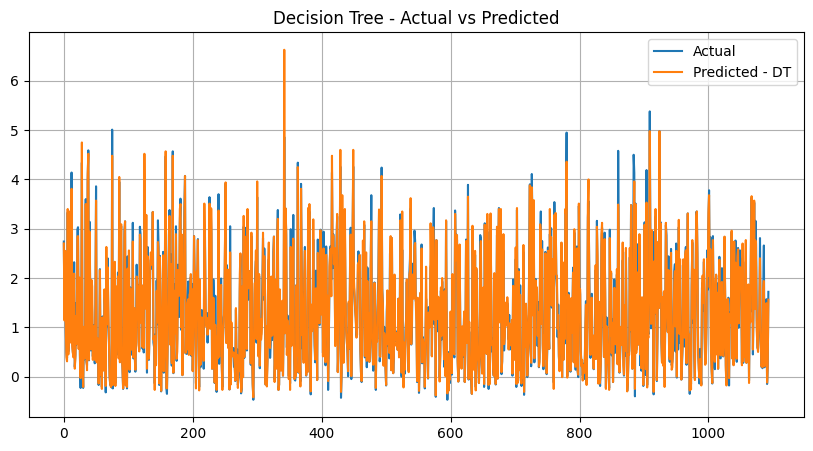

In [ ]:

# === 2. Decision Tree ===
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
joblib.dump(dt_model, 'dt_model.pkl')
y_pred_dt = dt_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

mask = y_test != 0
accuracy_dt = 100 - np.mean(np.abs((y_test[mask] - y_pred_dt[mask]) / y_test[mask])) * 100
print("Decision Tree")
print(f"RMSE: {rmse_dt:.4f}")
print(f"R² Score: {r2_dt:.4f}")
print(f"Approximate Percentage Accuracy: {accuracy_dt:.2f}%")

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_dt, label='Predicted - DT')
plt.title('Decision Tree - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


## SVM Model

Support Vector Machine
RMSE: 0.0801
R² Score: 0.9952
Approximate Percentage Accuracy: 78.85%


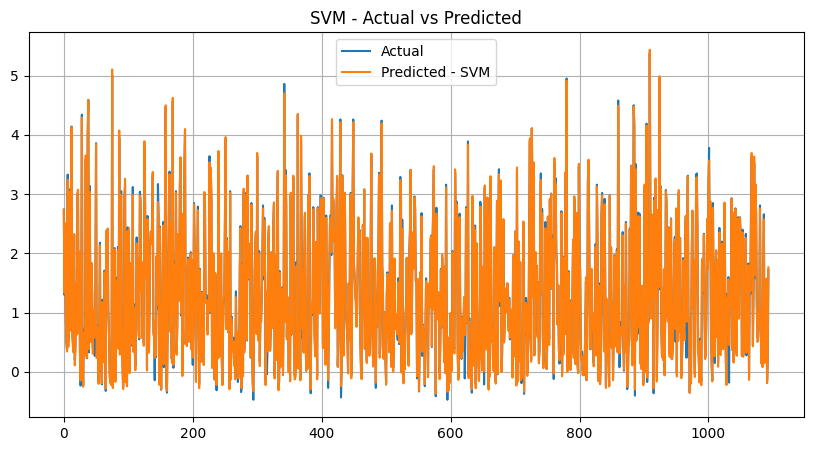

In [ ]:

# === 3. Support Vector Machine ===
from sklearn.svm import SVR
svm_model = SVR()
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, 'svm_model.pkl')
y_pred_svm = svm_model.predict(X_test)

mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
r2_svm = r2_score(y_test, y_pred_svm)

mask = y_test != 0
accuracy_svm = 100 - np.mean(np.abs((y_test[mask] - y_pred_svm[mask]) / y_test[mask])) * 100
print("Support Vector Machine")
print(f"RMSE: {rmse_svm:.4f}")
print(f"R² Score: {r2_svm:.4f}")
print(f"Approximate Percentage Accuracy: {accuracy_svm:.2f}%")

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_svm, label='Predicted - SVM')
plt.title('SVM - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


## ANN Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - mae: 0.1733
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Artificial Neural Network
RMSE: 0.2080
R² Score: 0.9676
Approximate Percentage Accuracy: 40.77%


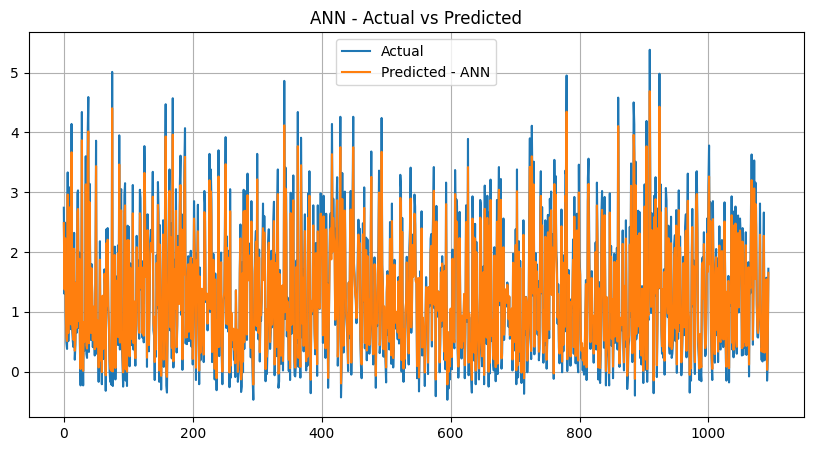

In [ ]:

# === 4. Artificial Neural Network (ANN) ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
ann_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

loss_ann, mae_ann = ann_model.evaluate(X_test, y_test)
y_pred_ann = ann_model.predict(X_test).flatten()

mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test, y_pred_ann)

mask = y_test != 0
accuracy_ann = 100 - np.mean(np.abs((y_test[mask] - y_pred_ann[mask]) / y_test[mask])) * 100
print("Artificial Neural Network")
print(f"RMSE: {rmse_ann:.4f}")
print(f"R² Score: {r2_ann:.4f}")
print(f"Approximate Percentage Accuracy: {accuracy_ann:.2f}%")

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_ann, label='Predicted - ANN')
plt.title('ANN - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## DNN Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Features and target
X = df1[['avgtemp_c', 'maxtemp_c', 'mintemp_c', 'avgwind_kph', 'avghumidity', 'totalprecip_mm', 'sunHour']]
y = df1['soil_moisture_delta']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set seed for reproducibility
tf.random.set_seed(42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['mse']
)

# Train the model and track history
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.1)


# Predict
y_pred_ann = model.predict(X_test).flatten()

# Evaluate


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
model.evaluate(X_test, y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0678 - mse: 0.0083


[0.06614305078983307, 0.007792901713401079]

In [ ]:
model.save('dnn_model.h5')

MAE: 0.0661, R²: 0.9942


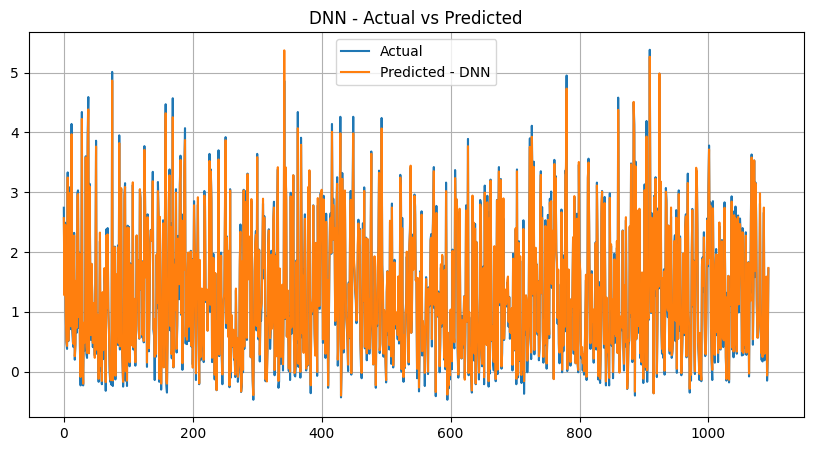

In [ ]:
mae = mean_absolute_error(y_test, y_pred_ann)
r2 = r2_score(y_test, y_pred_ann)

plt.figure(figsize=(10,5))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred_ann, label='Predicted - DNN')
plt.title('DNN - Actual vs Predicted')
plt.legend()
plt.grid(True)
print(f"MAE: {mae:.4f}, R²: {r2:.4f}")
plt.show()

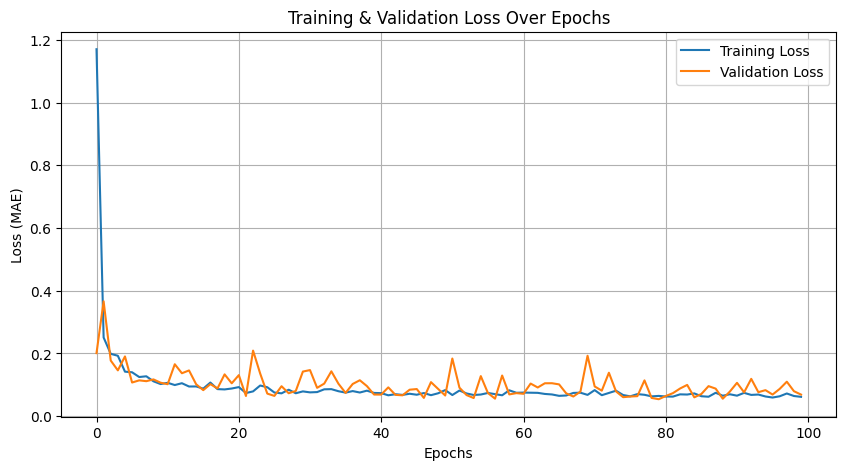

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.show()


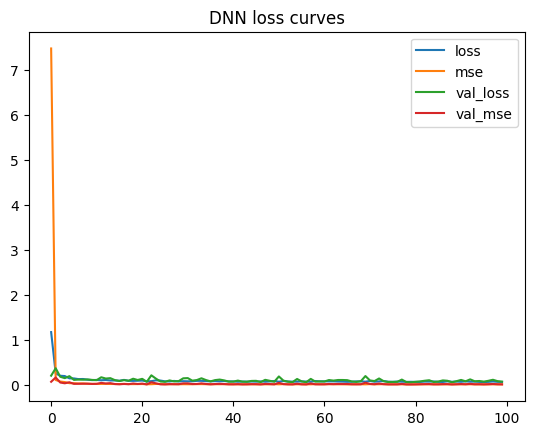

In [ ]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("DNN loss curves");

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as model_8)
model_9 = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

# Compile the model
model_9.compile(
    loss=tf.keras.losses.mae,
    optimizer='adam',
    metrics=['mse']
)

# Create a learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# Fit the model (passing lr_scheduler callback)
history_9 = model_9.fit(X_train,
                        y_train,
                        epochs=100,
                        callbacks=[lr_scheduler], validation_split=0.1)

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0969 - mse: 16.3368 - val_loss: 0.3305 - val_mse: 0.2104 - learning_rate: 1.0000e-04
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2853 - mse: 0.1781 - val_loss: 0.1928 - val_mse: 0.0718 - learning_rate: 1.1220e-04
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2007 - mse: 0.0906 - val_loss: 0.1784 - val_mse: 0.0569 - learning_rate: 1.2589e-04
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1875 - mse: 0.0721 - val_loss: 0.1630 - val_mse: 0.0444 - learning_rate: 1.4125e-04
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1716 - mse: 0.0575 - val_loss: 0.1602 - val_mse: 0.0423 - learning_rate: 1.5849e-04
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1631 - mse: 0.0489 - val_loss: 0.1450 - val_mse: 0.0333 - learning_rate: 1.7783e-04
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1533 - mse: 0.0424 - val_loss: 0.1391 - val_mse: 0.030

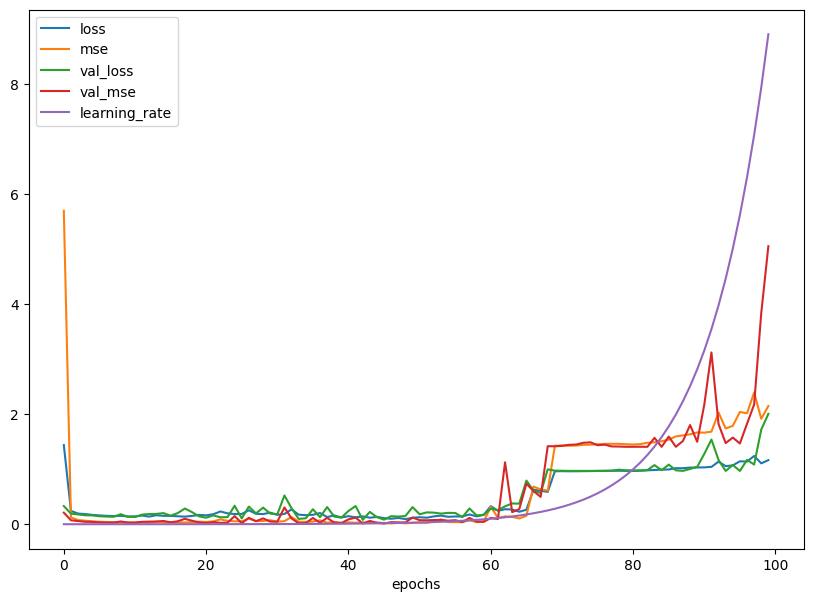

In [ ]:
pd.DataFrame(history_9.history).plot(figsize=(10, 7), xlabel="epochs");

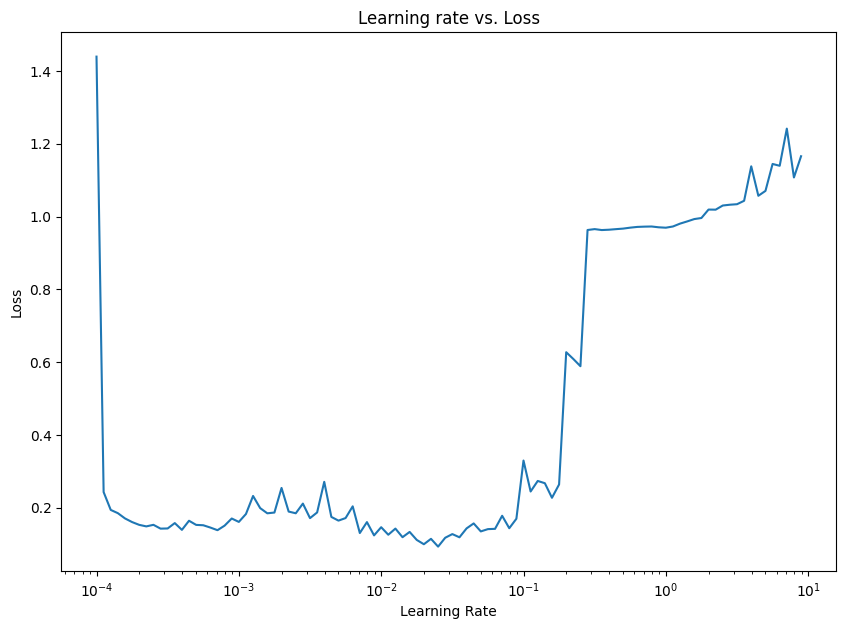

In [ ]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (tf.range(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history_9.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. Loss");

# Inputs

In [ ]:
input_date = '2025-04-25'
input_soil_type = 'Clay'
input_crop_type = 'Date'
input_area = 1100
input_initial_level = 20
input_max_level = 31

future_data = get_future_data('Berlin', input_date)

test_case = np.array([future_data[0]['avgtemp_c'], future_data[0]['maxtemp_c'], future_data[0]['mintemp_c'], future_data[0]['avgwind_kph'], future_data[0]['avghumidity'], future_data[0]['totalprecip_mm'], future_data[0]['sunHour']]) # Example input features
test_case = test_case.reshape(1, -1) # Reshape to match input shape

Error fetching data for 2025-04-25: Status code 400


IndexError: list index out of range

In [ ]:
test_case

# Actual Result

In [ ]:
import pandas as pd


# Initialize empty lists to store the calculated values
result = 0

# Loop through each row of the DataFrame

row = [

  future_data[0]['avgtemp_c'],            # avgtemp_c
  future_data[0]['maxtemp_c'],            # maxtemp_c
  future_data[0]['mintemp_c'],            # mintemp_c
  future_data[0]['avgwind_kph'],            # maxwind_kph (becomes avgwind_kph)
  future_data[0]['avghumidity'],            # avghumidity
  future_data[0]['totalprecip_mm'],           # totalprecip_mm
  future_data[0]['sunHour'],             # sunHour
  input_initial_level,            # initial_level / soil_moisture
  input_crop_type,       # crop_type
  input_soil_type,        # soil_type
  input_area,           # area
  input_max_level             # max_moisture
]



avgtemp_c = float(row[0])  # Convert to float for temperature
maxtemp_c = float(row[1])  # Convert to float for temperature
mintemp_c = float(row[2])  # Convert to float for temperature
maxwind_kph = float(row[3])  # Convert to float for wind speed
avghumidity = float(row[4])  # Convert to float for humidity
totalprecip_mm = float(row[5])  # Convert to float for precipitation
sunHours = float(row[6])  # Convert to float for sun hours
initial_level = float(row[7])  # Convert to float for initial soil moisture level
soil_level = float(initial_level)  # Use the same conversion for soil moisture
crop_type = row[8]  # Crop type stays as a string
soil_type = row[9]  # Soil type stays as a string
area = float(row[10])  # Convert to float for area in m²
max_level = float(row[11])  # Convert to float for maximum soil moisture level

calculated_solar_radition = calculate_solar_radiation(sunHours, maxtemp_c, mintemp_c)

et = calculate_et(
    temp=avgtemp_c,
    humidity=avghumidity,
    solar_radiation=calculated_solar_radition,
    wind_speed=maxwind_kph / 3.6
)
rain_contribution = calculate_rain_contribution(totalprecip_mm, soil_type)

crop_et = calculate_crop_et(et, crop_type, 'Late-season')

soil_level += rain_contribution
soil_level -= crop_et

if soil_level > max_level:
    soil_level = max_level

water_required = max_level - soil_level
if water_required < 0:
    water_required = 0

total_water_required_for_crop = water_required * area

result = total_water_required_for_crop

print(result)

# Load Models

#### Load DT Model

In [ ]:
loaded_dt_model = joblib.load('dt_model.pkl')

In [ ]:
predicted_soil_moisture = loaded_dt_model.predict(test_case)
print(f"Predicted soil moisture delta for the test case: {predicted_soil_moisture[0]}")

predicted_water_required = (input_max_level - (input_initial_level + calculate_rain_contribution(future_data[0]['totalprecip_mm'], input_soil_type)
- calculate_crop_et(predicted_soil_moisture[0], input_crop_type, 'Late-season'))) * input_area

print(f"Water required is {predicted_water_required:.2f} Liters")

In [ ]:
if(result < predicted_water_required):
  print(result / predicted_water_required * 100, '%')
else :
  print(predicted_water_required / result * 100, '%')

#### Load RF Model

In [ ]:
loaded_rf_model = joblib.load('rf_model.pkl')

In [ ]:
predicted_soil_moisture = loaded_rf_model.predict(test_case)
print(f"Predicted soil moisture delta for the test case: {predicted_soil_moisture[0]}")

predicted_water_required = (input_max_level - (input_initial_level + calculate_rain_contribution(future_data[0]['totalprecip_mm'], input_soil_type)
- calculate_crop_et(predicted_soil_moisture[0], input_crop_type, 'Late-season'))) * input_area

print(f"Water required is {predicted_water_required:.2f} Liters")

In [ ]:
if(result < predicted_water_required):
  print(result / predicted_water_required * 100, '%')
else :
  print(predicted_water_required / result * 100, '%')

#### Load SARIMAX Model

In [ ]:
loaded_sarimax_model = joblib.load('sarimax_model.pkl')


In [ ]:
results = loaded_sarimax_model.fit(disp=False)
forecast = results.get_forecast(steps=1, exog=test_case)
predicted_soil_moisture = forecast.predicted_mean
print(f"Predicted soil moisture delta for the test case: {predicted_soil_moisture.iloc[0]}")

predicted_water_required = (input_max_level - (input_initial_level + calculate_rain_contribution(future_data[0]['totalprecip_mm'], input_soil_type)
- calculate_crop_et(predicted_soil_moisture.iloc[0], input_crop_type, 'Late-season'))) * input_area

print(f"Water required is {predicted_water_required:.2f} Liters")

In [ ]:
if(result < predicted_water_required):
  print(result / predicted_water_required * 100, '%')
else :
  print(predicted_water_required / result * 100, '%')

#### Load SVM Model

In [ ]:
loaded_svm_model = joblib.load('svm_model.pkl')

In [ ]:
predicted_soil_moisture = loaded_svm_model.predict(test_case)
print(f"Predicted soil moisture delta for the test case: {predicted_soil_moisture[0]}")

predicted_water_required = (input_max_level - (input_initial_level + calculate_rain_contribution(future_data[0]['totalprecip_mm'], input_soil_type)
- calculate_crop_et(predicted_soil_moisture[0], input_crop_type, 'Late-season'))) * input_area

print(f"Water required is {predicted_water_required:.2f} Liters")

In [ ]:
if(result < predicted_water_required):
  print(result / predicted_water_required * 100, '%')
else :
  print(predicted_water_required / result * 100, '%')

#### Load XGBoost Model

In [ ]:
loaded_xgboost_model = joblib.load('xgb_model.pkl')

In [ ]:
predicted_soil_moisture = loaded_xgboost_model.predict(test_case)
print(f"Predicted soil moisture delta for the test case: {predicted_soil_moisture[0]}")

predicted_water_required = (input_max_level - (input_initial_level + calculate_rain_contribution(future_data[0]['totalprecip_mm'], input_soil_type)
- calculate_crop_et(predicted_soil_moisture[0], input_crop_type, 'Late-season'))) * input_area

print(f"Water required is {predicted_water_required:.2f} Liters")

In [ ]:
if(result < predicted_water_required):
  print(result / predicted_water_required * 100, '%')
else :
  print(predicted_water_required / result * 100, '%')

#### Load DNN Model

In [ ]:
# Load the saved model
loaded_dnn_model = tf.keras.models.load_model('dnn_model.h5')

In [ ]:
predicted_soil_moisture = loaded_dnn_model.predict(test_case).flatten()
print(f"Predicted soil moisture delta for the test case: {predicted_soil_moisture[0]}")

predicted_water_required = (input_max_level - (input_initial_level + calculate_rain_contribution(future_data[0]['totalprecip_mm'], input_soil_type)
- calculate_crop_et(predicted_soil_moisture[0], input_crop_type, 'Late-season'))) * input_area

print(f"Water required is {predicted_water_required:.2f} Liters")

In [ ]:
if(result < predicted_water_required):
  print(result / predicted_water_required * 100, '%')
else :
  print(predicted_water_required / result * 100, '%')

# Upload Models to MongoDB

In [ ]:
pip install pymongo

In [ ]:
import pymongo
import pickle
import time

In [ ]:
def save_model_to_db(model, client, db, dbconnection, model_name):
  #pickling the model
  pickled_model = pickle.dumps(model)

  myclient = pymongo.MongoClient(client)

  mydb = myclient[db]

  mycon = mydb[dbconnection]
  info = mycon.insert_one({model_name: pickled_model, 'name': model_name, 'created_time': time.time()})
  print(info.inserted_id, 'Uploaded Successfully')

  details = {
      'inserted_id': info.inserted_id,
      'name': model_name,
      'created_time': time.time()
  }
  return details


In [ ]:
def load_model_from_db(model_name, client, db, dbconnection):

  myclient = pymongo.MongoClient(client)

  mydb = myclient[db]

  mycon = mydb[dbconnection]

  data = mycon.find({'name': model_name})

  for i in data:
    json_data = i

  pickled_model = json_data[model_name]

  model = pickle.loads(pickled_model)

  return model

In [ ]:
details = save_model_to_db(model=loaded_dnn_model, client='',
                           db='Bachelor', dbconnection='', model_name='dnn_model')

In [ ]:
dnn = load_model_from_db(model_name='dnn_model', client='',
                         db='Bachelor', dbconnection='')